In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
raw_atlas_2019 = pd.read_csv('../data/processed/processed_atlas_2019.csv')
raw_atlas_2015 = pd.read_csv('../data/processed/processed_atlas_2015.csv')
raw_atlas_2010 = pd.read_csv('../data/processed/processed_atlas_2010.csv')
processed_atlas_2019 = raw_atlas_2019.copy()
processed_atlas_2015 = raw_atlas_2015.copy()
processed_atlas_2010 = raw_atlas_2010.copy()
processed_atlas_2019 = processed_atlas_2019.drop(columns=["CensusTract", "Unnamed: 0"], errors='ignore')
processed_atlas_2015 = processed_atlas_2015.drop(columns=["CensusTract", "Unnamed: 0"], errors='ignore')
processed_atlas_2010 = processed_atlas_2010.drop(columns=["CensusTract", "Unnamed: 0"], errors='ignore')
pd.set_option('display.max_columns', None)
processed_atlas_2019.head()

,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lakids1share,laseniors1share,lahunv1share,lalowi1share,POP2010,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,1.0,0.113,0.999747,0.034381,0.042803,0.012796,0.000972,0.046897,0.9919,0.2633,0.1144,0.0079,0.2411,0.051027,0.237971,0.053347,0.003138,0.294456,0.005712
1,1.0,0.179,0.999699,0.060601,0.051161,0.012391,0.014411,0.071724,0.5811,0.1869,0.0583,0.0900,0.2783,0.057916,0.369585,0.071889,0.041014,0.482488,0.015948
2,1.0,0.150,0.999719,0.098685,0.075475,0.025418,0.016030,0.079080,0.4600,0.1234,0.0596,0.0000,0.1418,0.090038,0.387192,0.050993,0.029351,0.467536,0.021763
3,1.0,0.028,0.999731,0.069669,0.085690,0.052342,0.003400,0.045057,0.3109,0.0789,0.0539,0.0046,0.0783,0.117086,0.210214,0.022344,0.004788,0.237346,0.002868
4,1.0,0.152,0.999770,0.169412,0.266948,0.065196,0.037241,0.155862,0.2455,0.0664,0.0336,0.0135,0.0545,0.287442,0.208248,0.031488,0.021364,0.261100,0.037858


In [6]:
input_columns = [
    'Urban', 'PovertyRate', 'MedianFamilyIncome', 'TractLOWI', 'TractKids', 'TractSeniors',
    'TractHUNV', 'TractSNAP', 'lapop1share', 'laseniors1share', 'lahunv1share', 
    'POP2010', 'LOWIRatio', 'SNAPRatio', 'HUNVRatio', 'FoodInsecurityIndex', 'LOWIWeighted' 
]

In [7]:
class Autoencoder_Food_Desert_Model(nn.Module):
    def __init__(self, input_dim=17, latent_dim=8):
        super(Autoencoder_Food_Desert_Model, self).__init__()
        
        #Encode our dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 12),
            nn.ReLU(True),
            nn.Linear(12, latent_dim)
        )
        
        #Decoding these dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 16),
            nn.ReLU(True),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        encoding_result = self.encoder(input)
        decoding_output = self.decoder(encoding_result)
        return decoding_output


In [8]:
atlas_tensor_2019 = torch.tensor(processed_atlas_2019[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2015 = torch.tensor(processed_atlas_2015[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2010 = torch.tensor(processed_atlas_2010[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2019.shape

torch.Size([72531, 17])

In [9]:
processed_atlas_2010.head()

,Urban,POP2010,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,TractSNAP,TractLOWI,TractKids,TractSeniors,TractHUNV,PovertyRate,MedianFamilyIncome,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,1,0.051027,0.709980,0.128283,0.717235,0.735282,0.045569,0.018391,0.024180,0.037569,0.006427,0.008096,0.1050,0.999740,0.167364,0.020921,0.026151,0.214435,0.003733
1,1,0.057916,0.222779,0.078728,0.288400,0.238209,0.046297,0.029885,0.051534,0.050401,0.005153,0.018620,0.1476,0.999699,0.314286,0.029954,0.052995,0.397235,0.011183
2,1,0.090038,0.420360,0.112892,0.421844,0.432805,0.015252,0.051034,0.078208,0.084255,0.008511,0.016354,0.0804,0.999705,0.306849,0.032908,0.029944,0.369701,0.009244
3,1,0.117086,0.435311,0.070944,0.463460,0.413773,0.002280,0.053333,0.072616,0.100886,0.012333,0.003076,0.0632,0.999726,0.219106,0.026448,0.004332,0.249886,0.006747
4,1,0.287442,0.255773,0.034686,0.235845,0.331996,0.014069,0.064368,0.107828,0.254285,0.011406,0.036108,0.0596,0.999745,0.132547,0.013004,0.020713,0.166264,0.009448


In [22]:
train_size = int(0.9 * len(atlas_tensor_2019))
val_size = len(atlas_tensor_2019) - train_size
train_dataset, val_dataset = random_split(atlas_tensor_2019, [train_size, val_size])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [24]:
model = Autoencoder_Food_Desert_Model(input_dim=17, latent_dim=8).to(device)

In [25]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [26]:
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
                
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader.dataset):.6f} | Val Loss: {val_loss/len(val_loader.dataset):.6f}")

train_model(model, nn.MSELoss(), optim.Adam(model.parameters(), lr=0.001), 50,
           DataLoader(train_dataset, batch_size=64, shuffle=True), DataLoader(val_dataset, batch_size=64, shuffle=False))

Epoch 1/50 | Train Loss: 0.009373 | Val Loss: 0.005010
Epoch 2/50 | Train Loss: 0.003827 | Val Loss: 0.001972
Epoch 3/50 | Train Loss: 0.001625 | Val Loss: 0.001427
Epoch 4/50 | Train Loss: 0.001208 | Val Loss: 0.001046
Epoch 5/50 | Train Loss: 0.000888 | Val Loss: 0.000782
Epoch 6/50 | Train Loss: 0.000830 | Val Loss: 0.000699
Epoch 7/50 | Train Loss: 0.000735 | Val Loss: 0.000679
Epoch 8/50 | Train Loss: 0.000672 | Val Loss: 0.000645
Epoch 9/50 | Train Loss: 0.000659 | Val Loss: 0.000596
Epoch 10/50 | Train Loss: 0.000650 | Val Loss: 0.000557
Epoch 11/50 | Train Loss: 0.002570 | Val Loss: 0.000531
Epoch 12/50 | Train Loss: 0.001011 | Val Loss: 0.000517
Epoch 13/50 | Train Loss: 0.000562 | Val Loss: 0.000465
Epoch 14/50 | Train Loss: 0.025507 | Val Loss: 0.000419
Epoch 15/50 | Train Loss: 0.000565 | Val Loss: 0.000390
Epoch 16/50 | Train Loss: 0.000371 | Val Loss: 0.000383
Epoch 17/50 | Train Loss: 0.000546 | Val Loss: 0.000354
Epoch 18/50 | Train Loss: 0.000364 | Val Loss: 0.000344
E

In [28]:
model.eval()
with torch.no_grad():
    latent_vectors = model.encoder(atlas_tensor_2019.to(device)).cpu().numpy()

In [29]:
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

In [31]:
clustered_df = raw_atlas_2019.copy()
clustered_df['Cluster'] = cluster_labels

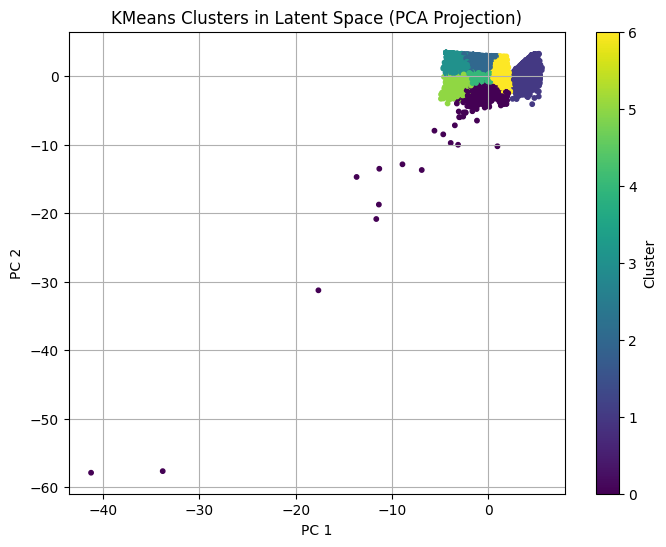

In [35]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('KMeans Clusters in Latent Space (PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [36]:
clustered_df.groupby('Cluster').mean(numeric_only=True)[[
    'PovertyRate', 'SNAPRatio', 'LOWIRatio', 'HUNVRatio', 
    'TractKids', 'TractSeniors', 'TractHUNV', 'TractSNAP', 
    'MedianFamilyIncome', 'FoodInsecurityIndex', 'LOWIWeighted'
]]


,PovertyRate,SNAPRatio,LOWIRatio,HUNVRatio,TractKids,TractSeniors,TractHUNV,TractSNAP,MedianFamilyIncome,FoodInsecurityIndex,LOWIWeighted
Cluster,,,,,,,,,,,
0,0.323352,0.117078,0.632391,0.097179,0.094718,0.023359,0.056374,0.201908,0.999686,0.846648,0.088282
1,0.131986,0.043119,0.314825,0.017453,0.082073,0.034933,0.011247,0.079922,0.999731,0.375397,0.022408
2,0.058311,0.013560,0.131561,0.030693,0.072207,0.031160,0.017141,0.022358,0.999811,0.175814,0.003326
3,0.070689,0.018893,0.170064,0.018660,0.078619,0.034440,0.011848,0.033850,0.999787,0.207617,0.005720
4,0.141174,0.047069,0.335795,0.044316,0.088951,0.032851,0.028778,0.089662,0.999734,0.427180,0.022916
5,0.217079,0.076535,0.460524,0.043582,0.093104,0.031643,0.027452,0.142531,0.999708,0.580641,0.049861
6,0.107284,0.035325,0.256240,0.018741,0.098666,0.035122,0.011972,0.068077,0.999757,0.310306,0.016451


In [37]:
clustered_df_cols = ['CensusTract', 'Cluster']
save_clustered_df = clustered_df[clustered_df_cols]
save_clustered_df.head()

,CensusTract,Cluster
0,1001020100,6
1,1001020200,4
2,1001020300,4
3,1001020400,3
4,1001020500,4


Clusters 0 and 5: High risk food deserts.

Clusters 1, 4, 6: Moderate/Low risk in becoming a food desert.

Cluster 2, 3: Low/no risk in becoming a food desert.

In [39]:
save_clustered_df['Cluster'].value_counts().sort_index()

Cluster
0     9171
1    17360
2     8780
3     7501
4    13733
5     9656
6     6330
Name: count, dtype: int64

In [40]:
save_clustered_df.to_csv('../data/processed/clustered_atlas_labels.csv', index=False)

In [42]:
cluster_map = {
    0: 0,
    5: 0,
    1: 1,
    4: 1,
    6: 1,
    2: 2,
    3: 2
}
random_forest_labels = save_clustered_df.copy()

random_forest_labels['Cluster'] = random_forest_labels['Cluster'].map(cluster_map)
random_forest_labels.to_csv('../data/processed/random_forest_labels.csv', index=False)
random_forest_labels.tail()

,CensusTract,Cluster
72526,56043000200,1
72527,56043000301,1
72528,56043000302,2
72529,56045951100,1
72530,56045951300,1


# Doing this for 2015/2010 data